# Sequence-to-Sequence Modeling
we will perform the task of translating Indian Names to Hindi, a sequence-to-sequence modeling task, using character-level conditional language models.



Once we executed the code, certain additional files will be created.
``` python
└─── SAPName
     ├─── SAPName_assignment.py
     ├─── src-tokenizer
     │    └─── tokenizer.pkl
     ├─── tgt-tokenizer
     │    └─── tokenizer.pkl
     ├─── rnn.enc-dec
     │    ├─── model.pt
     │    ├─── loss.json
     │    ├─── outputs.csv
     │    └─── metadata.json
     └─── rnn.enc-dec.attn
          ├─── model.pt
          ├─── loss.json
          ├─── outputs.csv
          └─── metadata.json
```


### Content

- Tokenization
- Agnostic Task-Specific Training
- Seq-2-Seq via RNN
- Seq-2-Seq via RNN with Attention
- Evaluation
- Decoding Strategies

## Setup

The following cells perform the basic setup such as importing the necessary packages.

In [ ]:
# Installs packages, if using locally
%pip install tqdm nltk matplotlib numpy pandas

In [ ]:
# Built-in imports, no installations required.

import os
import gc
import json
import math
import pickle
import subprocess
import collections
import unicodedata

In [ ]:
# 3rd-party package imports, may require installation if not on a platform such as Colab.

import numpy
import torch
import pandas as pd
import tqdm.auto as tqdm
import torch.nn as nn

import matplotlib
from matplotlib import pyplot
from nltk.translate import bleu_score
from torch.utils.data import TensorDataset, DataLoader

In [ ]:
# Find and load fonts that can display Hindi characters, for Matplotlib
result = subprocess.run([ 'fc-list', ':lang=hi', 'family' ], capture_output=True)
found_hindi_fonts = result.stdout.decode('utf-8').strip().split('\n')

matplotlib.rcParams['font.sans-serif'] = [
    'Source Han Sans TW', 'sans-serif', 'Arial Unicode MS',
    *found_hindi_fonts
]

In [ ]:
DIRECTORY_NAME = f"{STUDENT_SAP_NAME.replace(' ', '_')}_{STUDENT_SR_NUMBER}"

os.makedirs(DIRECTORY_NAME, exist_ok=True)

In [ ]:
def sync_vram():
    """ Synchronizes the VRAM across the GPUs, reclaiming unused memory. """
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.synchronize()

## Data Preparation

We'll load the data for the task, which comprises of a parallel corpus of Indian Names and their Hindi equivalents.

In [ ]:


# Download the training and validation datasets
!wget -O data.train.csv "https://docs.google.com/spreadsheets/d/1JpK9nOuZ2ctMrjNL-C0ghUQ4TesTrMER1-dTD_torAA/gviz/tq?tqx=out:csv&sheet=data.train.csv"
!wget -O data.valid.csv "https://docs.google.com/spreadsheets/d/1cKC0WpWpIQJkaqnFb7Ou7d0syFDsj6eEW7bM7GH3u2k/gviz/tq?tqx=out:csv&sheet=data.valid.csv"

--2024-04-17 05:18:39--  https://docs.google.com/spreadsheets/d/1JpK9nOuZ2ctMrjNL-C0ghUQ4TesTrMER1-dTD_torAA/gviz/tq?tqx=out:csv&sheet=data.train.csv
Resolving docs.google.com (docs.google.com)... 108.177.119.101, 108.177.119.100, 108.177.119.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘data.train.csv’

data.train.csv          [ <=>                ] 126.35K  --.-KB/s    in 0.02s   

2024-04-17 05:18:39 (6.76 MB/s) - ‘data.train.csv’ saved [129381]

--2024-04-17 05:18:39--  https://docs.google.com/spreadsheets/d/1cKC0WpWpIQJkaqnFb7Ou7d0syFDsj6eEW7bM7GH3u2k/gviz/tq?tqx=out:csv&sheet=data.valid.csv
Resolving docs.google.com (docs.google.com)... 108.177.119.101, 108.177.119.100, 108.177.119.139, ...
Connecting to docs.google.com (docs.google.com)|108.177.119.101|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/cs

In [ ]:


def read_dataframe(ds_type):
    """ Loads a dataframe based on the given partition type.

    Args:
        ds_type (str): Dataset type: train (train) or validation (valid)

    Returns:
        pd.DataFrame: Pandas Dataframe for the specified partition.
    """

    df = pd.read_csv(f"data.{ds_type}.csv", header=0)
    df = df[~df.isna()]
    df['Name'] = df['Name'].astype(str)
    df['Translation'] = df['Translation'].astype(str)
    return df

# Load the training and validation datasets
train_data      = read_dataframe("train")
validation_data = read_dataframe("valid")

print(f"Length of training data: {len(train_data)}\nLength of validation data: {len(validation_data)}")

Length of training data: 4484
Length of validation data: 400


In [ ]:
train_data.sample(n=5)

,Name,Translation
1567,joginder,जोगिंदर
595,bhupesh,भूपेश
1826,kripya,कृपया
4405,vishesh,विशेष
2976,rajkaranta,राजकारंत


Here are some examples from the training dataset. Note that the dataset may be noisy so some examples may not be perfect:

## Tokenization

Now with the data, you must first prepare a tokenization strategy for feeding name pairs as a sequence to different models. For English this could be as simple as using individual characters as tokens, but Hindi has accents (मात्राएँ), a larger set of vowels (स्वर), consonants (व्यंजन), and additional composition rules (half-letters, etc.), so such a simple strategy may not be effective.

In NLP literature, multiple strategies exist for automatically learning a suitable sub-word tokenization strategy from the given data. Such tokenizers exist in two types:
- Given a set of initial tokens, learn suitable combinations which are added as new tokens until a certain vocabulary size is reached. Examples of these include [BPE Tokenization](https://arxiv.org/abs/1508.07909) and [WordPiece Tokenization, introduced by the BERT paper](https://arxiv.org/abs/1810.04805).
- Given a large set of initial tokens, learn suitable rules to reduce the size of the vocabulary to a desired size. An example of this includes [SentencePiece Tokenization](https://arxiv.org/abs/1808.06226).

Given empirical results, these are popular strategies to learn tokenization automatically from given data.

In this section, you will implement a tokenizer for the given data. There could be multiple strategies to implement tokenizers:
- You can have a tokenizer that operates jointly over both languages or have separate tokenizers for English and Hindi.
- Your tokenizer can learn the tokenization from data (using any one of the techniques mentioned above) or can use a fixed set of rules for decomposition.

Implement the logic for any tokenizer of your choice in the class `Tokenizer` below. Make sure to adhere to the rules and constraints in the docstrings.

The tokenizer will learn a mapping of tokens to ids and vice versa and use these to map strings. This mapping can be built based on merge rules (BPE, WordPiece, etc.) or hand-crafted rules, in the `Tokenizer.train()` function. Additionally the tokenizer will also handle preprocessing and postprocessing of strings during the encoding phase (string to tokens).

In [ ]:
## ==== BEGIN EVALUATION PORTION

class Tokenizer:
    """ Represents the tokenizer for text data.
        Provides methods to encode and decode strings (as instance or as a batch). """

    def __init__(self,data):
        """ Initializes a new tokenizer.

            Any variables required in intermediate operations are declared here.
            You will also need to define things like special tokens and other things here.

            All variables declared in this function will be serialized
                and deserialized when loading and saving the Tokenizer.
            """

        # BEGIN CODE : tokenizer.init

        # ADD YOUR CODE HERE
        self.vocab ={}
        self.merges = {}
        self.get_vocab={}
        self.SOT_token = b'\x01'
        self.EOT_token = b'\x04'
        self.pad_token = b'\x00'
        self.add_start = False
        self.add_end =False
        self.strip_special = False

        # END CODE

    @classmethod
    def load(cls, path):
        """ Loads a pre-trained tokenizer from the given directory.
           This directory will have a tokenizer.pkl file that contains all the tokenizer variables.

        Args:
            path (str): Path to load the tokenizer from.
        """
        tokenizer_file = os.path.join(path, "tokenizer.pkl")

        if not os.path.exists(path) or not os.path.exists(os.path.join(path, "tokenizer.pkl")):
            raise ValueError(cls.load.__name__ + ": No tokenizer found at the specified directory")

        with open(tokenizer_file, "rb") as ifile:
            return pickle.load(ifile)

    def save(self, path):
        """ Saves a trained tokenizer to a given directory, inside a tokenizer.pkl file.

        Args:
            path (str): Directory to save the tokenizer in.
        """

        os.makedirs(path, exist_ok=True)
        with open(os.path.join(path, "tokenizer.pkl"), 'wb') as ofile:
            pickle.dump(self, ofile)
    #BEGIN CODE
    def get_stats(self,ids):
        counts = {}
        for pair in zip(ids, ids[1:]):
            counts[pair] = counts.get(pair, 0) + 1
        return counts

    def merge(self,ids, pair, idx):
        newids = []
        i = 0
        while i < len(ids):
            if i < len(ids) - 1 and ids[i] == pair[0] and ids[i+1] == pair[1]:
                newids.append(idx)
                i += 2
            else:
                newids.append(ids[i])
                i += 1
        return newids
    #END CODE
    def train(self, data, vocab_size):
        """ Trains a tokenizer to learn meaningful representations from input data.
            In the end, learns a vocabulary of a fixed size over the given data.
            Special tokens, if any, must not be counted towards this vocabulary.

        Args:
            data (list[str]): List of input strings from a text corpus.
            vocab_size (int): Final desired size of the vocab to be learnt.
        """

        # BEGIN CODE : tokenizer.train
        # ADD YOUR CODE HERE
        names = data
        i=[]
        for name in names:
            i.append(list(name.encode('utf-8')))
        text = [item for sublist in names for item in sublist]
        tokens = [item for sublist in i for item in sublist]

        vocab_size = vocab_size
        num_merges = vocab_size - 256
        ids = list(tokens)
        for i in range(num_merges):
            stats = self.get_stats(ids)
            pair = max(stats, key=stats.get)
            idx = 256 + i
            ids = self.merge(ids, pair, idx)
            self.merges[pair] = idx
        print("Tokenization Done")
        self.vocab = {idx: bytes([idx]) for idx in range(256)}
        for (p0, p1), idx in self.merges.items():
            self.vocab[idx] = self.vocab[p0] + self.vocab[p1]
        print("Vocab generated")
        # END CODE


    def pad(self, tokens, length):
        """ Pads a tokenized string to a specified length, for batch processing.

        Args:
            tokens (list[int]): Encoded token string to be padded.
            length (int): Length of tokens to pad to.

        Returns:
            list[int]: Token string padded to desired length.
        """

        # BEGIN CODE : tokenizer.pad

        # ADD YOUR CODE HERE
        if len(tokens) >= length:
            return tokens
        pad_length = length - len(tokens)

        start_padding =[]
        end_padding =[]
        padding = []
        get_vocab = self.get_vocabulary()
        if self.add_start and self.add_end:
            padding = [get_vocab[self.pad_token]] *pad_length
        else:
            padding = [get_vocab[self.pad_token]] * pad_length

        padded = tokens[:-1]+padding
        #if self.add_start:
        #    start_padding = [get_vocab[self.SOT_token]]
        #if self.add_end:
        #    end_padding = [get_vocab[self.EOT_token]]
        end_padding.append(tokens[-1])
        padded_tokens = start_padding + padded + end_padding
        return padded_tokens

        # END CODE

    def unpad(self, tokens):
        """ Removes padding from a token string.

        Args:
            tokens (list[int]): Encoded token string with padding.

        Returns:
            list[int]: Token string with padding removed.
        """

        # BEGIN CODE : tokenizer.unpad

        # ADD YOUR CODE HERE
        try:
            if self.strip_special:
                tokens = tokens[1:]
                tokens = tokens[:-1]
            first_pad_index = tokens.index(self.pad_token)
            tokens = tokens[:first_pad_index]
        except ValueError:
            return tokens

        # END CODE

    def get_special_tokens(self):
        """ Returns the associated special tokens.

            Returns:
                dict[str, int]: Mapping describing the special tokens, if any.
                    This is a mapping between a string segment (token) and its associated id (token_id).
        """

        # BEGIN CODE : tokenizer.get_special_tokens

        # ADD YOUR CODE HERE
        get_vocab =self.get_vocabulary()
        token_dict = {self.SOT_token : get_vocab[self.SOT_token],self.EOT_token : get_vocab[self.EOT_token]}
        return token_dict
        # END CODE

    def get_vocabulary(self):
        """ Returns the learnt vocabulary post the training process.

            Returns:
                dict[str, int]: Mapping describing the vocabulary and special tokens, if any.
                    This is a mapping between a string segment (token) and its associated id (token_id).
        """

        # BEGIN CODE : tokenizer.get_vocabulary

        # ADD YOUR CODE HERE
        self.get_vocab={}
        for key, value in self.vocab.items():
           self.get_vocab[value] = key

        return self.get_vocab
        # END CODE

    def encode(self, string, add_start=True, add_end=True):
        """ Encodes a string into a list of tokens.

        Args:
            string (str): Input string to be tokenized.
            add_start (bool): If true, adds the start of sequence token.
            add_end (bool): If true, adds the end of sequence token.
        Returns:
            list[int]: List of tokens (unpadded).
        """

        # BEGIN CODE : tokenizer.encode

        # ADD YOUR CODE HERE
        start =  self.SOT_token.decode('utf-8')
        end = self.EOT_token.decode('utf-8')

        if add_start:
            string = start +string
        if add_end:
            string = string+end
        tokens = list(string.encode("utf-8"))
        while len(tokens) >= 2:
            stats = self.get_stats(tokens)
            pair = min(stats, key=lambda p: self.merges.get(p, float("inf")))
            if pair not in self.merges:
                break # nothing else can be merged
            idx = self.merges[pair]
            tokens = self.merge(tokens, pair, idx)
        return tokens
        # END CODE

    def decode(self, tokens, strip_special=True):
        """ Decodes a string from a list of tokens.
            Undoes the tokenization, returning back the input string.

        Args:
            tokens (list[int]): List of encoded tokens to be decoded. No padding is assumed.
            strip_special (bool): Whether to remove special tokens or not.

        Returns:
            str: Decoded string.
        """

        # BEGIN CODE : tokenizer.decode
        if strip_special:
            tokens = tokens[1:-1]
        # ADD YOUR CODE HERE
        tks = b"".join(self.vocab[idx] for idx in tokens)
        text = tks.decode("utf-8", errors="replace")
        return text
        # END CODE


    def batch_encode(self, batch, padding=None, add_start=True, add_end=True):
        """Encodes multiple strings in a batch to list of tokens padded to a given size.

        Args:
            batch (list[str]): List of strings to be tokenized.
            padding (int, optional): Optional, desired tokenized length. Outputs will be padded to fit this length.
            add_start (bool): If true, adds the start of sequence token.
            add_end (bool): If true, adds the end of sequence token.

        Returns:
            list[list[int]]: List of tokenized outputs, padded to the same length.
        """
        self.add_start = add_start
        self.add_end =  add_end
        batch_output = [ self.encode(string, add_start, add_end) for string in batch ]
        if padding:
            for i, tokens in enumerate(batch_output):
                if len(tokens) < padding:
                    batch_output[i] = self.pad(tokens, padding)
        return batch_output

    def batch_decode(self, batch, strip_special=True):
        """ Decodes a batch of encoded tokens to normal strings.

        Args:
            batch (list[list[int]]): List of encoded token strings, optionally padded.
            strip_special (bool): Whether to remove special tokens or not.

        Returns:
            list[str]: Decoded strings after padding is removed.
        """
        self.strip_special =strip_special
        return [ self.decode(self.unpad(tokens), strip_special=strip_special) for tokens in batch ]

## ==== END EVALUATION PORTION

Now with the tokenizer class, initialize and train the tokenizers for processing the parallel corpus:

In [ ]:
## ==== BEGIN EVALUATION PORTION

# BEGIN CODE : tokenizer.create

# Initialize the tokenizers as per the desired strategy.
# ADD YOUR CODE HERE
english_train = train_data["Name"].to_list()
hindi_train = train_data["Translation"].to_list()
src_tokenizer = Tokenizer(english_train)
tgt_tokenizer = Tokenizer(hindi_train)

# END CODE

## ==== END EVALUATION PORTION

In [ ]:
## ==== BEGIN EVALUATION PORTION

# Edit the hyperparameters below as desired.
SRC_VOCAB_SIZE = 900
TGT_VOCAB_SIZE = 1000

# BEGIN CODE : tokenizer.training

# Train your tokenizer(s)
# ADD YOUR CODE HERE
src_tokenizer.train(english_train,SRC_VOCAB_SIZE)
tgt_tokenizer.train(hindi_train,TGT_VOCAB_SIZE)
# END CODE

## ==== END EVALUATION PORTION

Tokenization Done
Vocab generated
Tokenization Done
Vocab generated


In [ ]:
# Please do not change anything in the following cell

# Save the trained tokenizers
src_tokenizer.save(os.path.join(DIRECTORY_NAME, "src_tokenizer"))
tgt_tokenizer.save(os.path.join(DIRECTORY_NAME, "tgt_tokenizer"))

In [ ]:
# Please do not change anything in the following cell

def render_glyph(token):
    """ Renders a token, handling invalid bytes in a safe, error-proof manner. """

    token = token.decode('utf-8', errors='replace') if isinstance(token, bytes) else token
    return "".join([ c if unicodedata.category(c)[0] != "C" else f"\\u{ord(c):04x}" for c in token ])

def inverse_vocabulary(tokenizer):
    """ Generates an inverse vocabulary with rendered tokens.

    Args:
        tokenizer (Tokenizer): Tokenizer whose vocabulary must be used.
    """

    return { id: render_glyph(token) for token, id in tokenizer.get_vocabulary().items() }

def apply_inverse_vocab(tokens, inv_vocab):
    """ Decodes using the given inverse vocabulary.

    Args:
        tokens (list[int]): Tokens to process.
        inv_vocab (dict[int, str]): Inverse vocabulary for mapping ids to tokens.

    Returns:
        list[str]: Mapped token glyphs.
    """

    return [ inv_vocab[id] for id in tokens ]

We visualize a few outputs of the learnt tokenizers to assess their working:

In [ ]:
src_id_to_token = inverse_vocabulary(src_tokenizer)

for example in train_data['Name'].sample(n=5, random_state=20240227):
    print("Name           :", example)
    tokens = src_tokenizer.encode(example)
    print("Tokens         :", tokens)
    print("Tokens (glyphs):", apply_inverse_vocab(tokens, src_id_to_token))
    print("Decoded        :", src_tokenizer.decode(tokens), end='\n\n')

Name           : prya
Tokens         : [1, 321, 754, 4]
Tokens (glyphs): ['\\u0001', 'pr', 'ya', '\\u0004']
Decoded        : prya

Name           : jamal
Tokens         : [1, 597, 260, 4]
Tokens (glyphs): ['\\u0001', 'jam', 'al', '\\u0004']
Decoded        : jamal

Name           : jag
Tokens         : [1, 452, 4]
Tokens (glyphs): ['\\u0001', 'jag', '\\u0004']
Decoded        : jag

Name           : sampat
Tokens         : [1, 487, 410, 4]
Tokens (glyphs): ['\\u0001', 'sam', 'pat', '\\u0004']
Decoded        : sampat

Name           : amar
Tokens         : [1, 508, 4]
Tokens (glyphs): ['\\u0001', 'amar', '\\u0004']
Decoded        : amar



In [ ]:

tgt_id_to_token = inverse_vocabulary(tgt_tokenizer)

for example in train_data['Translation'].sample(n=5, random_state=20240227):
    print("Name           :", example)
    tokens = tgt_tokenizer.encode(example)
    print("Tokens         :", tokens)
    print("Tokens (glyphs):", apply_inverse_vocab(tokens, tgt_id_to_token))
    print("Decoded        :", tgt_tokenizer.decode(tokens), end='\n\n')

Name           : प्र्या
Tokens         : [1, 623, 313, 258, 4]
Tokens (glyphs): ['\\u0001', 'प्र', '्य', 'ा', '\\u0004']
Decoded        : प्र्या

Name           : जमाल
Tokens         : [1, 487, 293, 4]
Tokens (glyphs): ['\\u0001', 'जम', 'ाल', '\\u0004']
Decoded        : जमाल

Name           : जग
Tokens         : [1, 526, 4]
Tokens (glyphs): ['\\u0001', 'जग', '\\u0004']
Decoded        : जग

Name           : सम्पत्ति
Tokens         : [1, 477, 381, 603, 263, 4]
Tokens (glyphs): ['\\u0001', 'सम', '्प', 'त्त', 'ि', '\\u0004']
Decoded        : सम्पत्ति

Name           : अमर
Tokens         : [1, 421, 260, 4]
Tokens (glyphs): ['\\u0001', 'अम', 'र', '\\u0004']
Decoded        : अमर



In [ ]:
# Run some tests to ensure your tokenizer implementation works as intended.

instances = train_data['Translation'].sample(n=5, random_state=20240227).tolist()
try:
    max_length =max(map(
        lambda x: len(tgt_tokenizer.encode(x, add_start=False, add_end=False)),
        instances
    ))
    # Batch encode all instances with 'max' padding':
    tokenized_instances = tgt_tokenizer.batch_encode(
        instances, padding=max_length, add_start=False, add_end=False
    )

    #print(tokenized_instances)
    # Check if length of encoded strings is consistent with the expected length.
    assert all(len(tok_str) == max_length for tok_str in tokenized_instances)

except AssertionError:
    print((
        "[!] Your tokenizer does not encode strings correctly, "
        "ensure you have implemented padding appropriately!"
    ))

try:

    max_length = max(map(
        lambda x: len(tgt_tokenizer.encode(x, add_start=True, add_end=True)),
        instances
    ))
    # Batch encode all instances with 'max' padding':
    tokenized_instances = tgt_tokenizer.batch_encode(
        instances, padding=max_length, add_start=True, add_end=True
    )
    # Check if length of encoded strings is consistent with the expected length.
    assert all(len(tok_str) == max_length for tok_str in tokenized_instances)
    # Check if all strings start with the correct 'start' token.
    assert all(tok_str[0] == tokenized_instances[0][0] for tok_str in tokenized_instances)

    # Check if all strings end with the correct 'end' tokens.
    end_i = [ i for i, seq in enumerate(tokenized_instances) if len(tgt_tokenizer.unpad(seq)) == max_length ]
    pad_i = [ i for i, seq in enumerate(tokenized_instances) if len(tgt_tokenizer.unpad(seq)) <  max_length ]

    assert all(
        tokenized_instances[i][-1] == tokenized_instances[end_i[0]][-1]
        for i in end_i
    )
    assert all(
        tokenized_instances[i][-1] == tokenized_instances[pad_i[0]][-1]
        for i in pad_i
    )
    pad_lengths = [ tokenized_instances[i].index(tokenized_instances[end_i[0]][-1]) for i in pad_i ]
    assert all(
        all(tok == tokenized_instances[pad_i[0]][-1] for tok in tokenized_instances[i][plen+1:])
        for i, plen in zip(pad_i, pad_lengths)
    )

except AssertionError:
    print((
        "[!] Your tokenizer does not encode strings correctly, "
        "ensure you have used start and end tokens appropriately!"
    ))

We now abstract away the tokenizer into a pytorch compatible TokenizedDataset that will handle the tokenization internally:

In [ ]:
# Please do not change anything in the following cell

class TokenizerDataset(TensorDataset):
    """ Abstraction of the tokenizer functions as a pytorch dataset. """

    def __init__(self, data, src_tokenizer, tgt_tokenizer, src_padding=None, tgt_padding=None):
        """ Initializes the dataset.

        Args:
            data: DataFrame of input and output strings.
            src_tokenizer (Tokenizer): Tokenizer for the source language.
            tgt_tokenizer (Tokenizer): Tokenizer for the target language.
            src_padding (int, optional): Padding length for the source text. Defaults to None.
            tgt_padding (int, optional): Padding length for the target text. Defaults to None.
        """

        self.data = data
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.src_padding = src_padding
        self.tgt_padding = tgt_padding

    def collate(self, batch):
        """ Collates data instances into a batch of tokenized tensors.

        Args:
            batch (list[tuple]): List of x, y pairs.

        Returns:
            tuple[torch.Tensor|PackedSequence, torch.Tensor|PackedSequence]: pair of tokenized tensors.
        """

        x_batch = [ data[0] for data in batch ]
        y_batch = [ data[1] for data in batch ]

        x_batch = self.src_tokenizer.batch_encode(x_batch, self.src_padding)
        y_batch = self.tgt_tokenizer.batch_encode(y_batch, self.tgt_padding)

        if self.src_padding is None:
            x_batch = torch.nn.utils.rnn.pack_sequence([ torch.tensor(tokens) for tokens in x_batch ], False)
        else:
            x_batch = torch.tensor(x_batch)

        if self.tgt_padding is None:
            y_batch = torch.nn.utils.rnn.pack_sequence([ torch.tensor(tokens) for tokens in y_batch ], False)
        else:
            y_batch = torch.tensor(y_batch)

        return x_batch, y_batch

    def __getitem__(self, index):
        """ Returns the nth instance from the dataset.

        Args:
            index (int): Index of the instance to retrieve.

        Returns:
            tuple[str, str]: Untokenized instance pair.
        """

        return (
            self.data['Name'][index],
            self.data['Translation'][index]
        )

    def __len__(self):

        """ Returns the length of the dataset.

        Returns:
            int: Length of the dataset.
        """
        return len(self.data)

## Model-Agnostic Training

Next, we'll implement a Trainer to train different models, since the data and tokenizer remains the same for all models.

This trainer will receive the model, a loss function, an optimizer, a training and (optionally) a validation dataset and use these to train (and validate) the model.

The trainer will also take care of handling checkpoints for training, which can be used to resume training across sessions.

Derived classes can also be defined to handle different architectures, as to be done in the model-specific classes below.

In [ ]:
## ==== BEGIN EVALUATION PORTION

class Trainer:
    """ Performs model training in a model-agnostic manner.
        Requires specifying the model instance, the loss criterion to optimize,
          the optimizer to use and the directory to save data to.
    """

    def __init__(self, directory, model, criterion, optimizer):
        """ Initializes the trainer.

        Args:
            directory (str): Directory to save checkpoints and the model data in.
            model (torch.nn.Module): Torch model (must inherit `torch.nn.Module`) to train.
            criterion (torch.nn.Function): Loss criterion, i.e., the loss function to optimize for training.
            optimizer (torch.optim.Optimizer): Optimizer to use for training.
        """

        self.model            = model
        self.optimizer        = optimizer
        self.criterion        = criterion
        self.directory        = directory
        self.last_checkpoint  = 0
        self.loss_history     = { 'train': [], 'valid': [] }

        os.makedirs(self.directory, exist_ok=True)
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'



    @staticmethod
    def make_dataloader(dataset, shuffle_data=True, batch_size=64, collate_fn=None):
        """ Create a dataloader for a torch Dataset.

        Args:
            dataset (torch.utils.data.Dataset): Dataset to process.
            shuffle_data (bool, optional): If true, shuffles the data. Defaults to True.
            batch_size (int, optional): Number of items per batch. Defaults to 8.
            collate_fn (function, optional): Function to use for collating instances to a batch.

        Returns:
            torch.utils.data.DataLoader: Dataloader over the given data, post processing.
        """

        # BEGIN CODE : trainer.make_dataloader

        # ADD YOUR CODE HERE


        # Create DataLoader
        return DataLoader(dataset,
                          batch_size=batch_size, shuffle=shuffle_data, collate_fn=collate_fn)
        # END CODE

    def train_step(self, x_batch, y_batch):
        """ Performs a step of training, on the training batch.

        Args:
            x_batch (torch.Tensor): Input batch.
            y_batch (torch.Tensor): Output batch.

        Returns:
            float: Training loss with the current model, on this batch.
        """

        # BEGIN CODE : trainer.train_step

        # ADD YOUR CODE HERE
        self.model.train()
        self.optimizer.zero_grad()
        x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)
        outputs = self.model(x_batch)
        loss = self.criterion(outputs, y_batch)
        loss.backward()
        self.optimizer.step()
        return loss.item()

        # END CODE

    def eval_step(self, validation_dataloader):
        """ Perfoms an evaluation step, on the validation dataloader.

        Args:
            validation_dataloader (torch.utils.data.DataLoader): Dataloader for the validation dataset.

        Returns:
            float: Validation loss with the current model checkpoint.
        """

        # BEGIN CODE : trainer.eval_step

        # ADD YOUR CODE HERE
        self.model.eval()
        total_loss = 0.0
        with torch.no_grad():
            for x_batch, y_batch in validation_dataloader:
                x_batch, y_batch = x_batch.to(self.device), y_batch.to(self.device)
                outputs = self.model(x_batch)
                loss = self.criterion(outputs, y_batch)
                total_loss += loss.item() * len(x_batch)
        return total_loss / len(validation_dataloader.dataset)
        # END CODE

    def train(self, train_dataset, validation_dataset=None,
              num_epochs=10, batch_size=8, shuffle=True,
              save_steps=100, eval_steps=100, collate_fn=None):
        """ Handles the training loop for the model.

        Args:
            train_dataset (torch.utils.data.Dataset): Dataset to train on.
            validation_dataset (torch.utils.data.Dataset, optional): Data to validate on. Defaults to None.
            num_epochs (int, optional): Number of epochs to train for. Defaults to 10.
            batch_size (int, optional): Number of items to process per batch. Defaults to 8.
            shuffle (bool, optional): Whether to shuffle the data or not. Defaults to True.
            save_steps (int, optional): Number of steps post which a checkpoint should be saved. Defaults to 100.
            eval_steps (int, optional): Number of steps post which the model should be evaluated. Defaults to 100.
            collate_fn (function, optional): Function to use for collating instances to a batch.
        """

        current_checkpoint = 0
        self.model.to(self.device)
        self.model.train()

        with tqdm.tqdm(total = math.ceil(len(train_dataset) / batch_size) * num_epochs) as pbar:
            for epoch in range(num_epochs):
                train_dataloader      = self.make_dataloader(train_dataset, shuffle, batch_size, collate_fn)
                if validation_dataset is not None:
                    validation_dataloader = self.make_dataloader(validation_dataset, shuffle, batch_size, collate_fn)

                for batch, (x_batch, y_batch) in enumerate(train_dataloader):
                    pbar.set_description(f"Epoch {epoch+1} / {num_epochs}")

                    # If we are resuming training, skip this iteration
                    if current_checkpoint < self.last_checkpoint:
                        current_checkpoint += 1
                        pbar.update()
                        continue

                    # Do a step of training
                    loss = self.train_step(x_batch, y_batch)
                    self.loss_history['train'].append(loss)
                    pbar.set_postfix({ 'batch': batch+1, 'loss': loss })

                    current_checkpoint += 1
                    pbar.update()

                    # Evaluate after every eval_steps
                    if (current_checkpoint) % eval_steps == 0:
                        if validation_dataset is not None:
                            val_loss = self.eval_step(validation_dataloader)
                            self.loss_history['valid'].append(val_loss)
                        else:
                            val_loss = None

                        print('[>]', f"epoch #{epoch+1:{len(str(num_epochs))}},",
                              f"batch #{batch+1:{len(str(len(train_dataloader)))}}:",
                              "loss:", f"{loss:.8f}", '|', "val_loss:", f"{val_loss:.8f}")

                    # Save after every save_steps
                    if (current_checkpoint) % save_steps == 0:
                        self.save(current_checkpoint, { 'loss': loss, 'checkpoint': current_checkpoint })

                    # free unused resources
                    sync_vram()

            self.save(current_checkpoint)

    def resume(self):
        """ Resumes training session from the most recent checkpoint. """

        if checkpoints := os.listdir(self.directory):
            self.last_checkpoint = max(map(lambda x: int(x[11:]), filter(lambda x: 'checkpoint-' in x, checkpoints)))
            checkpoint_dir = os.path.join(self.directory, f"checkpoint-{self.last_checkpoint}")
            self.model.load_state_dict(torch.load(
                os.path.join(checkpoint_dir, "model.pt"),
                map_location=self.device
            ))
            self.model.to(self.device)
            self.optimizer.load_state_dict(torch.load(
                os.path.join(checkpoint_dir, "optimizer.pt"),
                map_location=self.device
            ))
            with open(os.path.join(checkpoint_dir, "loss.json"), 'r', encoding='utf-8') as ifile:
                self.loss_history = json.load(ifile)

    def save(self, checkpoint=None, metadata=None):
        """ Saves an associated model or a training checkpoint.

            If a checkpoint is specified, saves a checkpoint specific directory with optimizer data
                so that training can be resumed post that checkpoint.

        Args:
            checkpoint (int, optional): Checkpoint index. Defaults to None.
            metadata (dict[str, any], optional): Additional metadata to save alongside a checkpoint. Defaults to None.
        """

        if checkpoint is not None:
            checkpoint_dir = os.path.join(self.directory, f"checkpoint-{checkpoint}")
            os.makedirs(checkpoint_dir, exist_ok=True)
            torch.save(self.model.state_dict(), os.path.join(checkpoint_dir, "model.pt"))
            torch.save(self.optimizer.state_dict(), os.path.join(checkpoint_dir, "optimizer.pt"))
            with open(os.path.join(checkpoint_dir, "loss.json"), "w+", encoding='utf-8') as ofile:
                json.dump(self.loss_history, ofile, ensure_ascii=False, indent=2)
            if metadata:
                with open(os.path.join(checkpoint_dir, "metadata.json"), "w+", encoding='utf-8') as ofile:
                    json.dump(metadata, ofile, ensure_ascii=False, indent=2)
        else:
            torch.save(self.model, os.path.join(self.directory, "model.pt"))
            with open(os.path.join(self.directory, "loss.json"), "w+", encoding='utf-8') as ofile:
                json.dump(self.loss_history, ofile, ensure_ascii=False, indent=2)
            if metadata:
                with open(os.path.join(self.directory, "metadata.json"), "w+", encoding='utf-8') as ofile:
                    json.dump(metadata, ofile, ensure_ascii=False, indent=2)

## ==== END EVALUATION PORTION



```
# This is formatted as code
```

To test that the trainer works, try training a simple MLP network:

In [ ]:
X_train = torch.rand((500, 2))                      # (N x 2)
X_dev   = torch.rand((20 , 2))                      # (N x 2)

Y_train = (X_train[:, 0] - X_train[:, 1])[:, None]  # (N x 1)
Y_dev   = (X_dev  [:, 0] - X_dev  [:, 1])[:, None]  # (N x 1)

dummy_train_dataset = TensorDataset(X_train, Y_train)
dummy_val_dataset   = TensorDataset(X_dev  , Y_dev  )

In [ ]:
model = torch.nn.Sequential(
    torch.nn.Linear(2, 4),
    torch.nn.ReLU(),
    torch.nn.Linear(4, 1)
)

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

trainer = Trainer("mlp", model, loss_fn, optimizer)
trainer.train(dummy_train_dataset, dummy_val_dataset, batch_size=10, save_steps=300)

  0%|          | 0/500 [00:00<?, ?it/s]

[>] epoch # 2, batch #50: loss: 0.12096294 | val_loss: 0.15805119
[>] epoch # 4, batch #50: loss: 0.04749147 | val_loss: 0.13935223
[>] epoch # 6, batch #50: loss: 0.08682593 | val_loss: 0.12376974
[>] epoch # 8, batch #50: loss: 0.09808310 | val_loss: 0.10280435
[>] epoch #10, batch #50: loss: 0.02991457 | val_loss: 0.08223411


## Seq-2-Seq Modeling with RNNs

In this section, we will implement an encoder-decoder network using RNNs, to learn a conditional language model for the task of translating the names to Hindi.

You can use any type of RNN for this purpose: `RNN`, `GRU`, `LSTM`, etc. Consult the pytorch documentation for additional information.

Additional tips for training:
- Use regularization: Dropout, etc.
- Use a suitable optimizer, such as Adam.
- Format data accordingly before passing it to the trainer, using the helper functions.
- Do we need to pad sequences when processing inputs as a batch?

In [ ]:
## ==== BEGIN EVALUATION PORTION

class RNNEncoderDecoderLM(torch.nn.Module):
    """ Implements an Encoder-Decoder network, using RNN units. """

    # Feel free to add additional parameters to __init__
    def __init__(self, src_vocab_size, tgt_vocab_size, embd_dims, hidden_size, num_layers=1, dropout=0.1):
        """ Initializes the encoder-decoder network, implemented via RNNs.

        Args:
            src_vocab_size (int): Source vocabulary size.
            tgt_vocab_size (int): Target vocabulary size.
            embd_dims (int): Embedding dimensions.
            hidden_size (int): Size/Dimensions for the hidden states.
        """

        super(RNNEncoderDecoderLM, self).__init__()

        # Dummy parameter to track the model device. Do not modify.
        self._dummy_param = torch.nn.Parameter(torch.Tensor(0), requires_grad=False)

        # BEGIN CODE : enc-dec-rnn.init
        # ADD YOUR CODE HERE
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.encoder_embedding = nn.Embedding(src_vocab_size,embd_dims)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size,embd_dims)

        self.dropout = nn.Dropout(dropout)

        self.encoder_rnn = nn.GRU(input_size=embd_dims,hidden_size=hidden_size,num_layers=num_layers,dropout=dropout,batch_first=True)
        self.decoder_rnn = nn.GRU(input_size=embd_dims,hidden_size=hidden_size,num_layers=num_layers,dropout=dropout,batch_first=True)

        self.fc = nn.Linear(hidden_size,tgt_vocab_size)

        # END CODE

    @property
    def device(self):
        """ Returns the device the model parameters are on. """
        return self._dummy_param.device

    def forward(self, inputs, decoder_inputs, decoder_hidden_state=None):
        """ Performs a forward pass over the encoder-decoder network.

            Accepts inputs for the encoder, inputs for the decoder, and hidden state for
                the decoder to continue generation after the given input.

        Args:
            inputs (torch.Tensor): tensor of shape [batch_size?, max_seq_length]
            decoder_inputs (torch.Tensor): tensor of shape [batch_size?, 1]
            decoder_hidden_state (any): tensor to represent decoder hidden state from time step T-1.

        Returns:
            tuple[torch.Tensor, any]: output from the decoder, and associated hidden state for the next step.
            Decoder outputs should be log probabilities over the target vocabulary.
        """

        # BEGIN CODE : enc-dec-rnn.forward

        # ADD YOUR CODE HERE

        #print(inputs.shape)
        if decoder_hidden_state is None:
            src_embedding = self.dropout(self.encoder_embedding(inputs))
            encoder_outputs, encoder_hidden = self.encoder_rnn(src_embedding)
            encoder_state =  encoder_hidden
            decoder_hidden_state = encoder_state



        tgt_embedding = self.dropout(self.decoder_embedding(decoder_inputs))

        decoder_outputs, hidden_state = self.decoder_rnn(tgt_embedding,decoder_hidden_state)

        outputs =  self.fc(decoder_outputs)
        out_probs = nn.functional.log_softmax(outputs,dim=-1)
        return (out_probs,hidden_state)
        # END CODE

    def log_probability(self, seq_x, seq_y):
        """ Compute the conditional log probability of seq_y given seq_x, i.e., log P(seq_y | seq_x).

        Args:
            seq_x (torch.tensor): Input sequence of tokens.
            seq_y (torch.tensor): Output sequence of tokens.

        Returns:
            float: Log probability of seq_y given seq_x
        """

        # BEGIN CODE : enc-dec-rnn.log_probability


        #never needed this cell
        #can be wrong also, untested
        with torch.no_grad():

            decoder_hidden_state = None

            log_prob = 0.0

            for i in range(seq_y.size(1)):  # Loop through each token in seq_y
                decoder_input = seq_y[:, i:i+1]  # Current token
                decoder_output, decoder_hidden_state = self.forward(seq_x, decoder_input, decoder_hidden_state)
                output_probs =decoder_output

                # Gather the log probability of the true next token
                true_next_token_probs = output_probs[range(output_probs.size(0)), seq_y[:, i]]
                log_prob += true_next_token_probs

            return log_prob.sum().item()
        # END CODE

## ==== END EVALUATION PORTION

To train the above model, implement for training and evaluation steps in the `RNNEncoderDecoderTrainer` class below:

In [ ]:
## ==== BEGIN EVALUATION PORTION

class RNNEncoderDecoderTrainer(Trainer):
    """ Performs model training for RNN-based Encoder-Decoder models. """

    def __init__(self, directory, model, criterion, optimizer):
        """ Initializes the trainer.

        Args:
            directory (str): Directory to save checkpoints and the model data in.
            model (torch.nn.Module): Torch model to train.
            criterion (torch.nn.Function): Loss Criterion.
            optimizer (torch.optim.Optimizer): Optimizer to use.
        """

        super(RNNEncoderDecoderTrainer, self).__init__(directory, model, criterion, optimizer)

    @staticmethod
    def make_dataloader(dataset, shuffle_data=True, batch_size=8, collate_fn=None):
        """ Create a dataloader for a torch Dataset.

        Args:
            dataset (torch.utils.data.Dataset): Dataset to process.
            shuffle_data (bool, optional): If true, shuffles the data. Defaults to True.
            batch_size (int, optional): Number of items per batch. Defaults to 8.
            collate_fn (function, optional): Function to collate instances in a batch.

        Returns:
            torch.utils.data.DataLoader: Dataloader over the given data, post processing.
        """

        # BEGIN CODE : rnn-enc-dec-trainer.make_dataloader

        # ADD YOUR CODE HERE
        return DataLoader(dataset=dataset,shuffle=shuffle_data,batch_size=batch_size,collate_fn=collate_fn)
        # END CODE

    def train_step(self, x_batch, y_batch):
        """ Performs a step of training, on the training batch.

        Args:
            x_batch (torch.Tensor): Input batch tensor, of shape [batch_size, *instance_shape].
              For RNNs this is [batch_size, src_padding] or a torch.nn.utils.rnn.PackedSequence of varying lengths per batch (depends on padding).
            y_batch (torch.Tensor): Output batch tensor, of shape [batch_size, *instance_shape].
              For RNNs this is [batch_size, tgt_padding] or a torch.nn.utils.rnn.PackedSequence of varying lengths per batch (depends on padding).

        Returns:
            float: Training loss with the current model, on this batch.
        """

        # BEGIN CODE : rnn-enc-dec-trainer.train_step

        # ADD YOUR CODE HERE
        #self.model = self.model.to('cpu')
        self.model.train()
        self.optimizer.zero_grad()


        x_batch = x_batch.to(self.device)
        y_batch = y_batch.to(self.device)

        # init
        decoder_hidden_state = None


        loss = 0
        for i in range(y_batch.shape[1] - 1):
            decoder_input = y_batch[:, i:i + 1]
            decoder_output_probs, decoder_hidden_state = self.model(x_batch, decoder_input, decoder_hidden_state)
        #[32,20,256]
        #[1,20,256]
            target_next_token = y_batch[:, i + 1:i + 2]
            step_loss = self.criterion(decoder_output_probs.squeeze(dim=1), target_next_token.squeeze(dim=1))
            loss += step_loss


        loss /= y_batch.shape[1]


        loss.backward()
        self.optimizer.step()

        return loss.item()

        # END CODE

    def eval_step(self, validation_dataloader):
        """ Perfoms an evaluation step, on the validation dataloader.

        Args:
            validation_dataloader (torch.utils.data.DataLoader): Dataloader for the validation dataset.

        Returns:
            float: Validation loss with the current model checkpoint.
        """

        # BEGIN CODE : rnn-enc-dec-trainer.eval_step

        # ADD YOUR CODE HERE
        self.model.eval()


        total_loss = 0.0
        num_batches = 0


        with torch.no_grad():

            for x_batch, y_batch in validation_dataloader:

                x_batch = x_batch.to(self.device)
                y_batch = y_batch.to(self.device)


                decoder_hidden_state = None
                loss = 0
                for i in range(y_batch.shape[1] - 1):
                    decoder_input = y_batch[:, i:i + 1]
                    decoder_output_probs, decoder_hidden_state = self.model(x_batch, decoder_input, decoder_hidden_state)


                    target_next_token = y_batch[:, i + 1:i + 2]
                    step_loss = self.criterion(decoder_output_probs.squeeze(dim=1), target_next_token.squeeze(dim=1))
                    loss += step_loss


                total_loss += loss.item()
                num_batches += 1


        avg_validation_loss = total_loss / y_batch.shape[1]

        return avg_validation_loss

        # END CODE

## ==== END EVALUATION PORTION

In [ ]:
## == BEGIN EVALUATION PORTION



# BEGIN CODE : rnn-enc-dec.params

# Add parameters related to the model here.
rnn_enc_dec_params = {
    'src_vocab_size': 900,
    'tgt_vocab_size': 1000,
    'embd_dims'     : 256,
    'hidden_size'   : 512,
    'dropout'       : 0.2,
    'num_layers'    : 2
}

# Add parameters related to the dataset processing here.
rnn_enc_dec_data_params = dict(
    src_padding=20,
    tgt_padding=20,
)

# Add parameters related to training here.
rnn_enc_dec_training_params = dict(
    num_epochs=100,
    batch_size=512,
    shuffle=True,
    save_steps=100,
    eval_steps=100
)

# END CODE

# Do not forget to set a deterministic seed.
torch.manual_seed(42)

model = RNNEncoderDecoderLM(**rnn_enc_dec_params)

# BEGIN CODE : rnn-enc-dec.train

# ADD YOUR CODE HERE
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.CrossEntropyLoss()

# END CODE

trainer = RNNEncoderDecoderTrainer(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec"),
    model, criterion, optimizer
)

## == END EVALUATION PORTION

In [ ]:


train_dataset      = TokenizerDataset(train_data     , src_tokenizer, tgt_tokenizer, **rnn_enc_dec_data_params)
validation_dataset = TokenizerDataset(validation_data, src_tokenizer, tgt_tokenizer, **rnn_enc_dec_data_params)
print(len(train_dataset))
print(len(validation_dataset))
rnn_enc_dec_train_data = dict(
    train_dataset=train_dataset,
    validation_dataset=validation_dataset,
    collate_fn=train_dataset.collate
)

# Resume training from the last checkpoint, if interrupted midway, else begins training from scratch.
trainer.resume()

# Train as per specified training parameters.
trainer.train(**rnn_enc_dec_train_data, **rnn_enc_dec_training_params)

4484
400


  0%|          | 0/900 [00:00<?, ?it/s]

[>] epoch # 12, batch #1: loss: 0.81154633 | val_loss: 0.85843658
[>] epoch # 23, batch #2: loss: 0.59754705 | val_loss: 0.70350766
[>] epoch # 34, batch #3: loss: 0.36356419 | val_loss: 0.54841967
[>] epoch # 45, batch #4: loss: 0.13650066 | val_loss: 0.39187639
[>] epoch # 56, batch #5: loss: 0.06467275 | val_loss: 0.38211679
[>] epoch # 67, batch #6: loss: 0.07015299 | val_loss: 0.39818833
[>] epoch # 78, batch #7: loss: 0.03012995 | val_loss: 0.35284312
[>] epoch # 89, batch #8: loss: 0.20535700 | val_loss: 0.38349190
[>] epoch #100, batch #9: loss: 0.02831502 | val_loss: 0.36140840


In [ ]:


# Save the final model, with additional metadata.
trainer.save(metadata={
    'model'   : rnn_enc_dec_params,
    'data'    : rnn_enc_dec_data_params,
    'training': rnn_enc_dec_training_params
})

To validate training, look at sample translations for different examples, and probabilities assigned to different outputs.

Extensive evaluation and comparison against other approaches will be carried out later.

In [ ]:
import numpy as np
def rnn_greedy_generate(model, seq_x, src_tokenizer, tgt_tokenizer, max_length):
    """ Given a source string, translate it to the target language using the trained model.
        This function should perform greedy sampling to generate the results.

    Args:
        model (nn.Module): RNN Type Encoder-Decoder Model
        seq_x (str): Input string to translate.
        src_tokenizer (Tokenizer): Source language tokenizer.
        tgt_tokenizer (Tokenizer): Target language tokenizer.
        max_length (int): Maximum length of the target sequence to decode.

    Returns:
        str: Generated string for the given input in the target language.
    """

    # BEGIN CODE : enc-dec-rnn.greedy_generate

    # ADD YOUR CODE HERE

    seq_x_tokens = src_tokenizer.encode(seq_x)
    seq_x_tokens = src_tokenizer.pad(seq_x_tokens,max_length)
    seq_x_tensor = torch.tensor([seq_x_tokens],device='cuda')
    #print(seq_x_tensor)
    eot = tgt_tokenizer.EOT_token
    sot = tgt_tokenizer.SOT_token
    pad = tgt_tokenizer.pad_token

    special_tgt =tgt_tokenizer.get_special_tokens()
    tgt_vocab = tgt_tokenizer.get_vocabulary()
    eot_idx = special_tgt[eot]
    pad_idx = tgt_vocab[pad]
    with torch.no_grad():
        decoded_tokens = []
        decoder_hidden_state = None
        decoder_input = torch.tensor([[special_tgt[sot]]],device='cuda')  # <BOS> token
        decoded_tokens.append(decoder_input.item())
        for _ in range(max_length):

            decoder_output, decoder_hidden_state = model(seq_x_tensor, decoder_input, decoder_hidden_state)
            output_probs = decoder_output
            predicted_token_index = torch.argmax(output_probs, dim=-1)

            decoded_tokens.append(predicted_token_index.item())
            if predicted_token_index ==eot_idx:
                break
            #decoder_hidden_state = hidden_state
            decoder_input = torch.tensor([[predicted_token_index]],device='cuda')

        #remove padding

        idx = decoded_tokens.index(pad_idx)
        #print(idx)
        decoded_tokens = decoded_tokens[:idx+1]
        #print(decoded_tokens)
        decoded_tokens[-1] =4
        decoded_string = tgt_tokenizer.decode(decoded_tokens)

    return decoded_string




    # END CODE

In [ ]:
# Please do not change anything in the following cell.

for _, row in train_data.sample(n=5, random_state=42).iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )

    print("Name                      :", row['Name'])
    print("Translation (Expected)    :", row['Translation'])
    print("Translation (Model)       :", y_pred)

    print()

Name                      : al0k
Translation (Expected)    : आलोक
Translation (Model)       : आलोक

Name                      : sufia
Translation (Expected)    : सूफिया
Translation (Model)       : सूफिया

Name                      : firoz
Translation (Expected)    : फिरोज़
Translation (Model)       : फिरोज़

Name                      : gouri
Translation (Expected)    : गौरी
Translation (Model)       : गौरी

Name                      : chhaya
Translation (Expected)    : छाया
Translation (Model)       : छाया



In [ ]:
# Please do not change anything in the following cell.

for _, row in validation_data.sample(n=5, random_state=42).iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )

    print("Name                      :", row['Name'])
    print("Translation (Expected)    :", row['Translation'])
    print("Translation (Model)       :", y_pred)

    print()

Name                      : mhosin
Translation (Expected)    : मोहसीन
Translation (Model)       : मैसमिन

Name                      : qadeem
Translation (Expected)    : क़दीम
Translation (Model)       : क़दीम

Name                      : ashiqu
Translation (Expected)    : आशिक़
Translation (Model)       : आशिकू

Name                      : midhana
Translation (Expected)    : मिधना
Translation (Model)       : मूना

Name                      : divakar
Translation (Expected)    : दिवाकर
Translation (Model)       : दिवराज



In [ ]:


output_data = []
for _, row in validation_data.iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )
    output_data.append({ 'Name': row['Name'], 'Translation': y_pred })

pd.DataFrame.from_records(output_data).to_csv(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec", "outputs.csv"), index=False
)

In [ ]:


# Release resources
if 'trainer' in globals():
    del trainer

if 'model' in globals():
    del model

sync_vram()

## Seq-2-Seq Modeling with RNN + Attention

In this module, we will augment the Encoder-Decoder architecture to utilize attention, by implementing an Attention module that attends over the representations / inputs from the encoder.

Many approaches have been proposed in literature towards implementing attention. You are free to explore and use any implementation of your choice.

Some popular approaches are desribed in the original [paper by Bahdanau et al., 2014 on NMT](https://arxiv.org/abs/1409.0473) and an [exploratory paper by Luong et al, 2015](https://arxiv.org/abs/1508.04025) which explores different effective approaches to attention, including global and local attention.

In [ ]:
## ==== BEGIN EVALUATION PORTION

class AttentionModule(torch.nn.Module):
    """ Implements an attention module """

    # free to add additional parameters to __init__
    def __init__(self, input_size):
        """ Initializes the attention module.
            Feel free to declare any parameters as required. """

        super(AttentionModule, self).__init__()

        # BEGIN CODE : attn.init

        self.W = nn.Linear(input_size,input_size)
        self.U = nn.Linear(input_size,input_size)
        self.V = nn.Linear(input_size,1)
        # END CODE

    def forward(self, encoder_outputs, decoder_hidden_state):
        """ Performs a forward pass over the module, computing attention scores for inputs.

        Args:
            encoder_outputs (torch.Tensor): Output representations from the encoder, of shape [batch_size?, src_seq_len, output_dim].
            decoder_hidden_state (torch.Tensor): Hidden state from the decoder at current time step, of appropriate shape as per RNN unit (with optional batch dim).

        Returns:
            torch.Tensor: Attentions scores for given inputs, of shape [batch_size?, 1, src_seq_len]
        """

        # BEGIN CODE : attn.forward


        #keys -> decoder_hidden
        #query -> encoder_outputs
        #permute keys due to batch first
        #print(f"h1:{decoder_hidden_state.shape}")
        decoder_hidden_state = decoder_hidden_state.permute(1,0,2)
        #print(f"h2:{decoder_hidden_state.shape}")
        max_len = encoder_outputs.shape[1]
        decoder_hidden_state = decoder_hidden_state.repeat(1,max_len,1)
        #print(f"h3:{decoder_hidden_state.shape}")
        scores = self.V(torch.tanh(self.U(decoder_hidden_state)+self.W(encoder_outputs)))
        #print(f"sc:{scores.shape}")
        scores = scores.permute(0,2,1)
        #print(f"sc1:{scores.shape}")
        attn = torch.nn.functional.softmax(scores, dim=-1)
        #print(f"attn:{attn.shape}")
        return attn

        # END CODE

## ==== END EVALUATION PORTION

In [ ]:
## ==== BEGIN EVALUATION PORTION

class RNNEncoderDecoderLMWithAttention(torch.nn.Module):
    """ Implements an Encoder-Decoder network, using RNN units, augmented with attention. """

    # free to add additional parameters to __init__
    def __init__(self,src_vocab_size, tgt_vocab_size, embd_dims, hidden_size, num_layers=1, dropout=0.1):
        """ Initializes the encoder-decoder network, implemented via RNNs.

        Args:
            src_vocab_size (int): Source vocabulary size.
            tgt_vocab_size (int): Target vocabulary size.
            embd_dims (int): Embedding dimensions.
            hidden_size (int): Size/Dimensions for the hidden states.
        """

        super(RNNEncoderDecoderLMWithAttention, self).__init__()

        # Dummy parameter to track the model device.
        self._dummy_param = torch.nn.Parameter(torch.Tensor(0), requires_grad=False)

        # BEGIN CODE : enc-dec-rnn-attn.init

        # ADD YOUR CODE HERE
        self.src_vocab_size = src_vocab_size
        self.tgt_vocab_size = tgt_vocab_size
        self.embd_dims = embd_dims
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.dropout = dropout

        self.encoder_embedding = nn.Embedding(src_vocab_size,embd_dims)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size,embd_dims)

        self.dropout = nn.Dropout(dropout)

        self.encoder_rnn = nn.GRU(input_size=embd_dims,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
        self.decoder_rnn = nn.GRU(input_size = hidden_size+embd_dims,hidden_size=hidden_size,num_layers=num_layers,batch_first=True)
        self.attention = AttentionModule(hidden_size)
        self.fc = nn.Linear(hidden_size,tgt_vocab_size)

        # END CODE

    @property
    def device(self):
        return self._dummy_param.device

    def log_probability(self, seq_x, seq_y):
        """ Compute the conditional log probability of seq_y given seq_x, i.e., log P(seq_y | seq_x).

        Args:
            seq_x (torch.tensor): Input sequence of tokens, of shape [src_seq_len] (no batch dim)
            seq_y (torch.tensor): Output sequence of tokens, of shape [tgt_seq_len] (no batch dim)

        Returns:
            float: Log probability of generating sequence y, given sequence x.
        """

        # BEGIN CODE : enc-dec-rnn-attn.probability


        #nowhere needed this
        log_prob = 0.0


        encoder_outputs, encoder_hidden = self.encoder_rnn(self.src_embedding(seq_x.unsqueeze(0)))


        decoder_input = torch.tensor([[0]])
        decoder_hidden_state=None

        for y in seq_y:

            output, decoder_hidden = self.decoder_rnn(torch.cat([self.tgt_embedding(decoder_input), encoder_hidden], dim=1), decoder_hidden_state)


            true_token_prob = output[0, y].log()


            log_prob += true_token_prob


            decoder_input = y.unsqueeze(0).unsqueeze(0)  # Prepare input for the next step

        return log_prob.item()

        # END CODE

    def attentions(self, seq_x, terminate_token, max_length):
        """ Obtain attention over a sequence for decoding to the target language.

        Args:
            seq_x (torch.tensor): Tensor representing the source sequence, of shape [src_seq_len] (no batch dim)
            terminate_token (int): Token to use as EOS, to stop generating outputs.
            max_length (int): Maximum length to use to terminate the sampling.

        Returns:
            tuple[torch.tensor, torch.tensor]:
                A tuple of two tensors: the attentions over individual output tokens ([tgt_seq_len, src_seq_len])
                and the best output tokens ([tgt_seq_len]) per sequence step, based on greedy sampling.
        """

        # BEGIN CODE : rnn-enc-dec-attn.attentions


        #batch_size = seq_x.size(0)  # Get batch size
        #print(se)

        seq_x_tensor = seq_x.unsqueeze(0)  # Add batch dimension
        decoder_inputs = torch.tensor([[1]]).to(self.device)

        decoder_hidden_state = None


        all_attentions = []
        best_output_tokens = []
        terminate_token =4

        for _ in range(max_length):
            #decoder_inputs = self.decoder_embedding(decoder_inputs)
            output, decoder_hidden_state, attn_weights = self.forward(seq_x_tensor, decoder_inputs, decoder_hidden_state, output_attention=True)
            #print(f"att w:{attn_weights.shape}")
            all_attentions.append(attn_weights.squeeze(1))
            #print(f"op shape:{output.shape}")
            best_token = torch.argmax(output, dim=-1).item()
            best_output_tokens.append(best_token)
            #print(f"bt:{best_token}")
            if best_token == terminate_token:
                break

            decoder_inputs = torch.tensor([[best_token]]).to(self.device)
        attn = torch.stack(all_attentions).to(self.device)
        best_pred = torch.tensor(best_output_tokens).to(self.device)
        attn = attn[:, 0, :]
        #print(f"fattn:{attn}")
        return (attn.cpu().detach().numpy(),best_pred)

        # END CODE

    def forward(self, inputs, decoder_inputs=None, decoder_hidden_state=None, output_attention=False):
        """ Performs a forward pass over the encoder-decoder network.

            Accepts inputs for the encoder, inputs for the decoder, and hidden state for
                the decoder to continue generation after the given input.

        Args:
            inputs (torch.Tensor): tensor of shape [batch_size?, src_seq_len]
            decoder_inputs (torch.Tensor): Decoder inputs, as tensor of shape [batch_size?, 1]
            decoder_hidden_state (any): tensor to represent decoder hidden state from time step T-1.
            output_attention (bool): If true, this function should also return the
                associated attention weights for the time step, of shape [batch_size?, 1, src_seq_len].

        Returns:
            tuple[torch.Tensor, any]: output from the decoder, and associated hidden state for the next step.

            Decoder outputs should be log probabilities over the target vocabulary.

        Example:
        >>> model = RNNEncoderDecoderWithAttention(*args, **kwargs)
        >>> output, hidden = model(..., output_attention=False)
        >>> output, hidden, attn_weights = model(..., output_attention=True)
        """

        # BEGIN CODE : enc-dec-rnn-attn.forward

        #print(f"dec ip:{decoder_inputs.shape}")
        batch_size = inputs.shape[0]

        #print(f"dc:{decoder_hidden_state.shape}")
        src_embedding = self.dropout(self.encoder_embedding(inputs))
        #print(f"src:{src_embedding.shape}")
        encoder_output,encoder_hidden = self.encoder_rnn(src_embedding)
        if decoder_hidden_state is None:
            decoder_hidden_state = encoder_hidden
        #print(f"eo:{encoder_output.shape}")
        #print(f"eh:{encoder_hidden.shape}")
        attn = self.attention(encoder_output,decoder_hidden_state)
        #print(f"attrnn:{attn.shape}")
        context = torch.bmm(attn,encoder_output)
        #print(f"ctx:{context.shape}")
        tgt_embedding = self.dropout(self.decoder_embedding(decoder_inputs))
        #print(f"tgt:{tgt_embedding.shape}")
        tgt_embedding = torch.cat((tgt_embedding,context),dim=2)
        #print(f"tgt1:{tgt_embedding.shape}")

        decoder_outputs, hidden_state = self.decoder_rnn(tgt_embedding,decoder_hidden_state)
        #print(f"do:{decoder_outputs.shape}")
        #print(f"dh:{hidden_state.shape}")
        outputs = self.fc(decoder_outputs)
        #print(f"ops:{outputs.shape}")
        out_probs = nn.functional.log_softmax(outputs,dim=-1)

        if output_attention:
            return (out_probs,hidden_state,attn)
        else:
            return (out_probs,hidden_state)
        # END CODE

## ==== END EVALUATION PORTION

In [ ]:
## == BEGIN EVALUATION PORTION



# BEGIN CODE : rnn-enc-dec-attn.params

# Add parameters related to the model here.
rnn_enc_dec_attn_params = {
    'src_vocab_size': 900,
    'tgt_vocab_size': 1000,
    'embd_dims'     : 256,
    'hidden_size'   : 512,
    'dropout'       : 0.1,
    'num_layers'    : 1
}

# Add parameters related to the dataset processing here.
rnn_enc_dec_attn_data_params = dict(
    src_padding=20,
    tgt_padding=20,
)

# Add parameters related to training here.
rnn_enc_dec_attn_training_params = dict(
    num_epochs=100,
    batch_size=512,
    shuffle=True,
    save_steps=100,
    eval_steps=100
)

# END CODE

# Do not forget to set a deterministic seed.
torch.manual_seed(42)

model = RNNEncoderDecoderLMWithAttention(**rnn_enc_dec_attn_params)

# BEGIN CODE : rnn-enc-dec-attn.train


optimizer = torch.optim.Adam(model.parameters(),lr=0.001)
criterion = nn.NLLLoss()


# END CODE

trainer = RNNEncoderDecoderTrainer(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec.attn"),
    model, criterion, optimizer
)

## == END EVALUATION PORTION

In [ ]:


train_dataset      = TokenizerDataset(train_data     , src_tokenizer, tgt_tokenizer, **rnn_enc_dec_attn_data_params)
validation_dataset = TokenizerDataset(validation_data, src_tokenizer, tgt_tokenizer, **rnn_enc_dec_attn_data_params)

rnn_enc_dec_attn_train_data = dict(
    train_dataset=train_dataset,
    validation_dataset=validation_dataset,
    collate_fn=train_dataset.collate
)

# Resume training from the last checkpoint, if interrupted midway, otherwise starts from scratch.
trainer.resume()

# Train as per specified training parameters.
trainer.train(**rnn_enc_dec_attn_train_data, **rnn_enc_dec_attn_training_params)

  0%|          | 0/900 [00:00<?, ?it/s]

[>] epoch # 12, batch #1: loss: 0.81321710 | val_loss: 0.86300888
[>] epoch # 23, batch #2: loss: 0.54308051 | val_loss: 0.82195759
[>] epoch # 34, batch #3: loss: 0.30289316 | val_loss: 0.50222278
[>] epoch # 45, batch #4: loss: 0.14785211 | val_loss: 0.39576793
[>] epoch # 56, batch #5: loss: 0.45209008 | val_loss: 0.72841783
[>] epoch # 67, batch #6: loss: 0.14860468 | val_loss: 0.49465904
[>] epoch # 78, batch #7: loss: 0.03086715 | val_loss: 0.37065191
[>] epoch # 89, batch #8: loss: 0.02512634 | val_loss: 0.35776920
[>] epoch #100, batch #9: loss: 0.02524326 | val_loss: 0.36734769


In [ ]:


# Save the final model, with additional metadata.
trainer.save(metadata={
    'model'   : rnn_enc_dec_attn_params,
    'data'    : rnn_enc_dec_attn_data_params,
    'training': rnn_enc_dec_attn_training_params
})

We can validate the model using a few simple tests as below:

In [ ]:


for _, row in train_data.sample(n=5, random_state=42).iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )

    print("Name                      :", row['Name'])
    print("Translation (Expected)    :", row['Translation'])
    print("Translation (Model)       :", y_pred)

    print()

Name                      : al0k
Translation (Expected)    : आलोक
Translation (Model)       : आलोक

Name                      : sufia
Translation (Expected)    : सूफिया
Translation (Model)       : सूफिया

Name                      : firoz
Translation (Expected)    : फिरोज़
Translation (Model)       : फिरोज़



Name                      : gouri
Translation (Expected)    : गौरी
Translation (Model)       : गौरी

Name                      : chhaya
Translation (Expected)    : छाया
Translation (Model)       : छाया



In [ ]:


for _, row in validation_data.sample(n=5, random_state=42).iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )

    print("Name                      :", row['Name'])
    print("Translation (Expected)    :", row['Translation'])
    print("Translation (Model)       :", y_pred)

    print()

Name                      : mhosin
Translation (Expected)    : मोहसीन
Translation (Model)       : मोसिनोस

Name                      : qadeem
Translation (Expected)    : क़दीम
Translation (Model)       : क़दीम

Name                      : ashiqu
Translation (Expected)    : आशिक़
Translation (Model)       : आशिकू

Name                      : midhana
Translation (Expected)    : मिधना
Translation (Model)       : मिसना

Name                      : divakar
Translation (Expected)    : दिवाकर
Translation (Model)       : दिवराज



It may also be useful to look at attention maps for different examples:

In [ ]:


def visualize_attention(src_glyphs, tgt_glyphs, attention, axes):
    axes.matshow(attention, cmap='bone')

    axes.set_xticks(numpy.arange(len(src_glyphs)), labels=src_glyphs)
    axes.set_yticks(numpy.arange(len(tgt_glyphs)), labels=tgt_glyphs)

/data5/home/anushkapa/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 108 (l) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/data5/home/anushkapa/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 112 (p) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/data5/home/anushkapa/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 92 (\) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/data5/home/anushkapa/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 117 (u) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/data5/home/anushkapa/.local/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48 (0) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/data5/home/anushkapa/.local/lib/python3.8/site-packages/IPython/core/pylabto

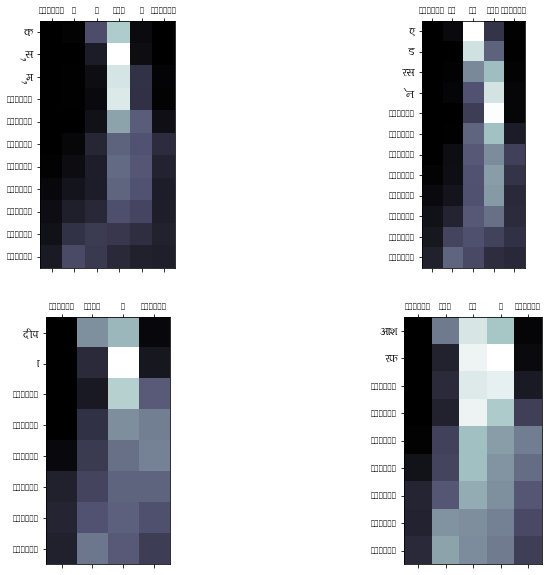

In [ ]:


pyplot.figure(figsize=(12, 10))

src_id_to_token = inverse_vocabulary(src_tokenizer)
tgt_id_to_token = inverse_vocabulary(tgt_tokenizer)

with torch.no_grad():
    for i, row in train_data.sample(n=4, random_state=69, ignore_index=True).iterrows():
        src_tokens = torch.tensor(src_tokenizer.encode(row['Name']),device='cuda')
        attentions, tgt_tokens = model.attentions(src_tokens, tgt_tokenizer.get_special_tokens()[tgt_tokenizer.EOT_token], max_length=50)
        src_glyphs = apply_inverse_vocab(src_tokens.tolist(), src_id_to_token)
        tgt_glyphs = apply_inverse_vocab(tgt_tokens.tolist(), tgt_id_to_token)
        axes = pyplot.subplot(2, 2, i+1)
        visualize_attention(src_glyphs, tgt_glyphs, attentions, axes)

In [ ]:


output_data = []
for _, row in validation_data.iterrows():
    y_pred = rnn_greedy_generate(
        model, row['Name'], src_tokenizer, tgt_tokenizer,
        max_length = rnn_enc_dec_data_params['tgt_padding']
    )
    output_data.append({ 'Name': row['Name'], 'Translation': y_pred })

pd.DataFrame.from_records(output_data).to_csv(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec.attn", "outputs.csv"), index=False
)

In [ ]:
# Please do not change anything in the following cell.

# Release resources
if 'trainer' in globals():
    del trainer

if 'model' in globals():
    del model

sync_vram()

## Evaluation

In the last few modules, we have implemented different approaches towards transliteration of Indian names to Hindi. To assess how well different systems perform, it is useful to compute different metrics, which assess different properties:

- **Accuracy**: From a parallel corpus, number of translations the model got exactly right. Higher the better. Note that this makes sense only for this task. and lacks granularity.
- **Edit Distance**: Number of edits at the character level (insertions, deletions, substitutions) required to transform your model's outputs to a reference translation. Lower the better.
- **Character Error Rate (CER)**: The rate at which your system/model makes mistakes at the character level. Lower the better.
- **Token Error Rate (TER)**: The rate at which your system/model makes mistakes at the token level. Lower the better. Depending on your tokenizer implementation, could be the same as CER.
- **BiLingual Evaluation Understudy (BLEU)**: Proposed by [Papineni et al., 2002](https://aclanthology.org/P02-1040/), BLEU is a metric that assess the quality of a translation against reference translations through assessing n-gram overlap. Higher the better.

Since accents and half-letters exist as separate characters in the Unicode specification, and can change the interpretation of the output, metrics that operate at the character level will treat these separately.

In [ ]:


class Evaluator:
    """ Class to handle all the logic concerning the evaluation of trained models.  """

    def __init__(self, src_tokenizer, tgt_tokenizer) -> None:
        """ Initializes the evaluator.

        Args:
            src_tokenizer (Tokenizer): Tokenizer for input strings in the source language.
            tgt_tokenizer (Tokenizer): Tokenizer for output strings in the target language.
        """

        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.src_tokenizer = src_tokenizer
        self.tgt_tokenizer = tgt_tokenizer
        self.decoding_method = None

    def set_decoding_method(self, decoding_method):
        """ Sets the decoding method to use with models.
                The evaluation function will use the set decoding method to generate outputs from the model.

        Args:
            decoding_method (function): Decoding method.
                Must accept the model instance, the input string, and tokenizers as arguments.
                Can accept additional arguments if required.
        """

        self.decoding_method = decoding_method

    @staticmethod
    def decompose(string):
        """ Decomposes a string into a set of tokens.

        Args:
            string (str): String to decompose.

        Returns:
            list[str]: List of characters from the string.
        """
        return unicodedata.normalize('NFKD', string).encode('utf-8')

    @staticmethod
    def levenshtein_distance(string1, string2):
        """ Computes the levensthein distance between two strings.

        Args:
            string1 (list[any]): Sequence A.
            string2 (list[any]): Sequence B.

        Returns:
            tuple[int, int, int]: Number of insertions + deletions, substitutions and no-ops.
        """

        costs = [
            [ 0 for j in range(len(string2)+1) ]
            for i in range(len(string1)+1)
        ]

        # Prepare matrix of costs.
        for i in range(len(string1)+1): costs[i][0] = i
        for j in range(len(string2)+1): costs[0][j] = j
        for i in range(1, len(string1)+1):
            for j in range(1, len(string2)+1):
                costs[i][j] = min(
                    costs[i][j-1] + 1,
                    costs[i-1][j] + 1,
                    costs[i-1][j-1] + (0 if string1[i-1] == string2[j-1] else 1)
                )

        # Decode matrix in backward manner for actual operation counts.
        c_ins_del, c_sub, c_noop = 0, 0, 0

        i, j = len(string1), len(string2)
        while i > 0 or j > 0:
            if i > 0 and costs[i][j] == costs[i-1][j] + 1:
                c_ins_del += 1
                i -= 1
            elif j > 0 and costs[i][j] == costs[i][j-1] + 1:
                c_ins_del += 1
                j -= 1
            elif i > 0 and j > 0:
                if string1[i-1] == string2[j-1]:
                    c_noop += 1
                else:
                    c_sub += 1
                i, j = i-1, j-1
            else:
                break

        return c_ins_del, c_sub, c_noop

    @staticmethod
    def accuracy(y_true, y_pred):
        """ Computes the accuracy of the predictions, against a reference set of predictions.

        Args:
            y_true (list[str]): Actual translations.
            y_pred (list[str]): Generated translations.

        Returns:
            float: Accuracy score, between 0 and 1.
        """
        return sum(yi_true == yi_pred for yi_true, yi_pred in zip(y_true, y_pred)) / len(y_pred)

    @classmethod
    def char_error_rate(cls, y_true, y_pred):
        """ Computes the character level error rate (CER) of the set of
            predictions against the reference translations.

        Args:
            y_true (list[str]): Actual translations.
            y_pred (list[str]): Generated translations.

        Returns:
            float: CER score, between 0 and 1. Lower the better.
        """

        cer_score = 0

        for yi_true, yi_pred in zip(y_true, y_pred):
            yi_true, yi_pred = cls.decompose(yi_true), cls.decompose(yi_pred)
            c_ins_del, c_sub, c_noop = cls.levenshtein_distance(yi_true, yi_pred)
            cer_score += (c_ins_del + c_sub) / (c_ins_del + c_sub + c_noop)

        return cer_score / len(y_true)

    def token_error_rate(self, y_true, y_pred):
        """ Computes the token level error rate (TER) of the set of
            predictions against the reference translations.

        Args:
            y_true (list[str]): Actual translations.
            y_pred (list[str]): Generated translations.

        Returns:
            float: TER score, between 0 and 1. Lower the better.
        """

        ter_score = 0

        for yi_true, yi_pred in zip(y_true, y_pred):
            yi_true = self.tgt_tokenizer.encode(yi_true, add_start=False, add_end=False)
            yi_pred = self.tgt_tokenizer.encode(yi_pred, add_start=False, add_end=False)
            t_ins_del, t_sub, t_noop = self.levenshtein_distance(yi_true, yi_pred)
            ter_score += (t_ins_del + t_sub) / (t_ins_del + t_sub + t_noop)

        return ter_score / len(y_true)

    @classmethod
    def bleu_score(cls, y_true, y_pred):
        """ Computes the average BLEU score of the set of predictions against the reference translations.

            Uses default parameters and equal weights for all n-grams, with max N = 4. (Thus computes BLEU-4).
            Uses a smoothing method for the case of missing n-grams.

        Args:
            y_true (list[str]): Actual translations.
            y_pred (list[str]): Generated translations.

        Returns:
            float: BLEU-4 score, the higher the better.
        """

        y_true = [ [ cls.decompose(yi) ] for yi in y_true ]
        y_pred = [ cls.decompose(yi) for yi in y_pred ]

        smoothing = bleu_score.SmoothingFunction()

        return bleu_score.corpus_bleu(
            y_true, y_pred,
            smoothing_function=smoothing.method1
        )

    def evaluate(self, model_path, data, reference_outputs, **decoding_kwargs):
        """ Performs the evaluation of a specified model over given data.

        Args:
            model_path (str): Path to load the model from. Must have a model.pt file.
            data (list[str]): List of input strings to translate.
            reference_outputs (list[str]): List of output strings to use as reference.
            decoding_kwargs (dict[str, any]): Additional arguments to forward to the decoding method.
                This could be for instance, max_length for a greedy decoding method.

        Raises:
            ValueError: If the decoding method is not set apriori.
        """

        if self.decoding_method is None:
            raise ValueError(f"{self.evaluate.__name__}: no decoding method is set, assign before use.")

        # Load the model to the active device.
        model = torch.load(os.path.join(model_path, 'model.pt'), map_location=self.device)

        # Set model use parameters.
        model.to(self.device)
        model.eval()

        # Generate outputs.
        generated_outputs = []
        with torch.no_grad():
            for seq_x in data:
                generated_outputs.append(self.decoding_method(
                    model, seq_x, self.src_tokenizer,
                    self.tgt_tokenizer, **decoding_kwargs
                ))

        accuracy_score = self.accuracy(reference_outputs, generated_outputs)
        cer_score      = self.char_error_rate(reference_outputs, generated_outputs)
        ter_score      = self.token_error_rate(reference_outputs, generated_outputs)
        blue_score     = self.bleu_score(reference_outputs, generated_outputs)

        print("EVALUATION:", ">", "accuracy:", f"{accuracy_score:.2%}")
        print("EVALUATION:", ">", "CER     :", f"{cer_score:.2%}")
        print("EVALUATION:", ">", "TER     :", f"{ter_score:.2%}")
        print("EVALUATION:", ">", "BLEU    :", f"{blue_score:.4f}")
        print()

        # Free resources once evaluation is complete.
        del model
        sync_vram()

In [ ]:


evaluator = Evaluator(src_tokenizer, tgt_tokenizer)

# Use greedy decoding for producing outputs.
evaluator.set_decoding_method(rnn_greedy_generate)

# Evaluate enc-dec-rnn
print("EVALUATION:", "enc-dec-rnn")
evaluator.evaluate(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec"),
    validation_data['Name'], validation_data['Translation'],
    max_length = rnn_enc_dec_data_params['tgt_padding']
)

# Evaluate enc-dec-rnn-attn
print("EVALUATION:", "enc-dec-rnn-attn")
evaluator.evaluate(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec.attn"),
    validation_data['Name'], validation_data['Translation'],
    max_length = rnn_enc_dec_attn_data_params['tgt_padding']
)

EVALUATION: enc-dec-rnn


EVALUATION: > accuracy: 32.00%
EVALUATION: > CER     : 17.64%
EVALUATION: > TER     : 35.59%
EVALUATION: > BLEU    : 0.7657

EVALUATION: enc-dec-rnn-attn
EVALUATION: > accuracy: 29.75%
EVALUATION: > CER     : 19.50%
EVALUATION: > TER     : 36.84%
EVALUATION: > BLEU    : 0.7430



## Decoding Strategies

A conditional language model aims to learn $P_\theta(y | x)$, that is, the probability of the target sequence being $y$ when the input sequence is $x$. This is modeled as $P_{\theta}(y | x) = \prod_{i=1}^{|y|} {P_\theta(y_i | x, y_{1:i-1})}$.

For translation, our goal is to find the sequence that maximizes this conditional probability, i.e. $y^* = \arg \max_{y} P_\theta(y | x)$. $y^*$ is then the 'best' translation for the input sequence $x$. However, computing probabilities for all possible $y$ to find the maximizer is intractable. As a result, decoding strategies are employed to produce reasonable approximations of $y^*$.

In the last module, you evaluated your models through different metrics, but the approach for generating outputs from the model was fixed to greedy decoding, where at each time step, the token to be produced is determined by $y_{i,greedy} := \arg \max_{y_i} P(y_i| x, y_{1:i-1})$. While this approach is fast, $P(y_{greedy}|x)$ may be much less than $P(y^*|x)$. Fortunately, better decoding strategies exist to produce better approximations, however at the cost of higher time complexity. Some of these are:

- **Beam-Search Decoding**: At every time step, retains $k$ candidate token generations, which are decoded individually (each path is referred as a beam) to obtain $k$ successors per beam. For the next time step, the best $k$ candidates are retained such that conditional probability of the sequence generated so far is maximized. Has a complexity of $O(kV|y|)$, where $V$ is the size of the target vocabulary, and $|y|$ is the target sequence length. Using $k=1$ makes it equivalent to greedy decoding. Implementations also employ length penalties to not be biased towards larger target sequences.

- **Viterbi Decoding**: A decoding technique based on the Viterbi algorithm, which is a dynamic programming algorithm that provides an efficient way of finding the "most likely state sequence in the maximum a posteriori probability sense of a process assumed to be a finite-state discrete-time Markov process". Works well under assumptions of a small target vocabulary size and conditional independence of feature vectors. The decoded sequence has the minimum error probability possible when compared to $y^*$, i.e., $P(y_{viterbi}|x) \sim P(y^* | x)$. Has a time complexity of $O(V^2|y|)$.

In the next cell, we will implement any preferred decoding strategy of your choice, and compare performances of different decoding strategies.

In [ ]:
## ==== BEGIN EVALUATION PORTION


# Set this variable to True if you choose to implement the function `rnn_better_generate` for the module.
ATTEMPTED_BONUS = True

## ==== END EVALUATION PORTION

print("EVALUATION:", "Attempted Bonus Module?", ATTEMPTED_BONUS)

EVALUATION: Attempted Bonus Module? True


In [ ]:
## ==== BEGIN EVALUATION PORTION
from queue import PriorityQueue
import operator


# Feel free to add additional parameters to rnn_better_generate, such as k for Beam Search Decoding.
# BEGIN CODE : enc-dec-rnn.better_generate
class BeamSearchNode(object):
    def __init__(self, hiddenstate, previousNode, wordId, logProb, length):
        self.h = hiddenstate
        self.prevNode = previousNode
        self.wordid = wordId
        self.logp = logProb
        self.leng = length

    def eval(self, alpha=1.0):
        reward = 0

        return self.logp / float(self.leng - 1 + 1e-6) + alpha * reward



def rnn_better_generate(model, seq_x, src_tokenizer, tgt_tokenizer, max_length, k=10, length_penalty_alpha=0.6):
    """ Given a source string, translate it to the target language using the trained model.
        This function should use a better decoding strategy than greedy decoding (see above) to generate the results.

    Args:
        model (nn.Module): RNN Type Encoder-Decoder Model
        seq_x (str): Input string to translate.
        src_tokenizer (Tokenizer): Source language tokenizer.
        tgt_tokenizer (Tokenizer): Target language tokenizer.
        max_length (int): Maximum length of the target sequence to decode.

    Returns:
        str: Generated string for the given input in the target language.
    """

    # ADD YOUR CODE HERE

    eot = tgt_tokenizer.EOT_token
    sot = tgt_tokenizer.SOT_token
    pad = tgt_tokenizer.pad_token
    seq_x_tokens = src_tokenizer.encode(seq_x)
    seq_x_tokens = src_tokenizer.pad(seq_x_tokens,max_length)
    seq_x_tensor = torch.tensor([seq_x_tokens],device='cuda')
    special_tgt =tgt_tokenizer.get_special_tokens()
    tgt_vocab = tgt_tokenizer.get_vocabulary()
    eot_idx = special_tgt[eot]
    sot_idx = special_tgt[sot]
    pad_idx = tgt_vocab[pad]
    beam_width = k
    topk = 1

    with torch.no_grad():
        decoded_batch = []
        decoder_hidden =None
        for idx in range(max_length):
            decoder_input = torch.tensor([[sot_idx]], device='cuda')

            #chars generated track
            endnodes = []
            number_required = min((topk + 1), topk - len(endnodes))


            node = BeamSearchNode(decoder_hidden, None, decoder_input, 0, 1)
            nodes = PriorityQueue()

            # enqueue
            nodes.put((-node.eval(), node))
            qsize = 1


            while True:
                # give up
                if qsize > 2000: break

                # top()
                score, n = nodes.get()
                decoder_input = n.wordid
                decoder_hidden = n.h

                if n.wordid.item() == eot_idx and n.prevNode != None:
                    endnodes.append((score, n))

                    if len(endnodes) >= number_required:
                        break
                    else:
                        continue

                # model pass
                decoder_output, decoder_hidden = model(seq_x_tensor,decoder_input, decoder_hidden)


                log_prob, indexes = torch.topk(decoder_output, beam_width)
                nextnodes = []

                for new_k in range(beam_width):
                    decoded_t = indexes[0][0][new_k].view(1, -1)
                    log_p = log_prob[0][0][new_k].item()

                    node = BeamSearchNode(decoder_hidden, n, decoded_t, n.logp + log_p, n.leng + 1)
                    score = -node.eval()
                    nextnodes.append((score, node))


                for i in range(len(nextnodes)):
                    score, nn = nextnodes[i]
                    nodes.put((score, nn))

                qsize += len(nextnodes) - 1


            if len(endnodes) == 0:
                endnodes = [nodes.get() for _ in range(topk)]

            utterances = []
            for score, n in sorted(endnodes, key=operator.itemgetter(0)):
                utterance = []
                utterance.append(n.wordid)
                # back pass
                while n.prevNode != None:
                    n = n.prevNode
                    utterance.append(n.wordid)

                utterance = utterance[::-1]
                utterances.append(utterance)

            decoded_batch.append(utterances)
        flattened_list = [int(tensor.item()) for sublist in decoded_batch[0] for tensor in sublist]
        p_idx = flattened_list.index(pad_idx)
        final_decoded = flattened_list[:p_idx+1]
        final_decoded[-1] =4
        decoded_string = tgt_tokenizer.decode(final_decoded)

        return decoded_string
        # END CODE
## ==== END EVALUATION PORTION

In [ ]:
## ==== BEGIN EVALUATION PORTION

# BEGIN CODE : decoding.init

# Add parameter values for your decoding strategy here.

decoding_params = dict(
    k=10
    #END CODE
)

## ==== END EVALUATION PORTION

In [ ]:
# Please do not change anything in the following cell.

evaluator = Evaluator(src_tokenizer, tgt_tokenizer)

# Use a different decoding for producing outputs.
if ATTEMPTED_BONUS:
    evaluator.set_decoding_method(rnn_better_generate)
else:
    evaluator.set_decoding_method(rnn_greedy_generate)

# Evaluate enc-dec-rnn
print("EVALUATION:", "enc-dec-rnn")
evaluator.evaluate(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec"),
    validation_data['Name'], validation_data['Translation'],
    max_length = rnn_enc_dec_data_params['tgt_padding'],
    **decoding_params
)

# Evaluate enc-dec-rnn-attn
print("EVALUATION:", "enc-dec-rnn-attn")
evaluator.evaluate(
    os.path.join(DIRECTORY_NAME, "rnn.enc-dec.attn"),
    validation_data['Name'], validation_data['Translation'],
    max_length = rnn_enc_dec_attn_data_params['tgt_padding'],
    **decoding_params
)

EVALUATION: enc-dec-rnn


EVALUATION: > accuracy: 32.25%
EVALUATION: > CER     : 17.57%
EVALUATION: > TER     : 35.24%
EVALUATION: > BLEU    : 0.7661

EVALUATION: enc-dec-rnn-attn
EVALUATION: > accuracy: 30.50%
EVALUATION: > CER     : 19.26%
EVALUATION: > TER     : 36.27%
EVALUATION: > BLEU    : 0.7442

